In [2]:
import mlflow
from camelyon.log_ops import TRACKING_URI

mlflow.set_tracking_uri(TRACKING_URI)

In [4]:
import seaborn as sns
import pandas as pd

learning_types = ['base', 'attention_induction', 'ltr']
random_states = ['2023', '2024', '2025', '2026', '2027']

all_rows = []
for learning in learning_types:
    for random_state in random_states:
        rows = mlflow.search_runs(
            experiment_names=["attention_induction"],
            filter_string=(
                f"params.learning = '{learning}' "
                f"and params.random_state = '{random_state}' "
                f"AND params.margin = '1.0' "
            )
        )
        if "params.morphology_value" in rows.columns:
            rows = rows[(rows["params.morphology_value"].isna() & rows["params.dataset"].isna())]
        else:
            rows = rows
        all_rows.append(rows)


# 모든 결과를 하나의 DataFrame으로 합치기
data = pd.concat(all_rows).reset_index(drop=True)
data["params.sampling_ratio"] = data["params.sampling_ratio"].astype(float)
data_view = data[["metrics.test_auroc", "metrics.test_prauc", "params.learning", "params.sampling_ratio"]]

# rename
data_view["params.learning"] = data_view["params.learning"].replace({"base":"AB-MIL", "attention_induction": "Attention induction", "ltr":"Rank induction"})

/tmp/ipykernel_973335/1865732960.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_view["params.learning"] = data_view["params.learning"].replace({"base":"AB-MIL", "attention_induction": "Attention induction", "ltr":"Rank induction"})


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0.4_Attention induction v.s. 0.4_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=2.857e-02 U_stat=1.000e+00
0.6_Attention induction v.s. 0.6_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=1.429e-02 U_stat=0.000e+00
0.8_Attention induction v.s. 0.8_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=1.714e-01 U_stat=4.000e+00
1.0_Attention induction v.s. 1.0_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=1.010e-01 U_stat=9.000e+00
0.2_Attention induction v.s. 0.2_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=2.429e-01 U_stat=5.000e+00
0.6_AB-MIL v.s. 0.6_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=1.429e-02 U_stat=0.000e+00
0.8_AB-MIL v.s. 0.8_Rank induction: Mann-Whitney-Wilcoxon test smaller, P_val=4.429e-01 U_stat=7.000e+00
1.0_AB-MIL v.s. 1.0_Rank induction: 

(<Axes: xlabel='Sampling Ratio (Fraction of Training Data Used)', ylabel='AUROC'>,
  <statannot.StatResult.StatResult at 0x7fbd7dc00040>])

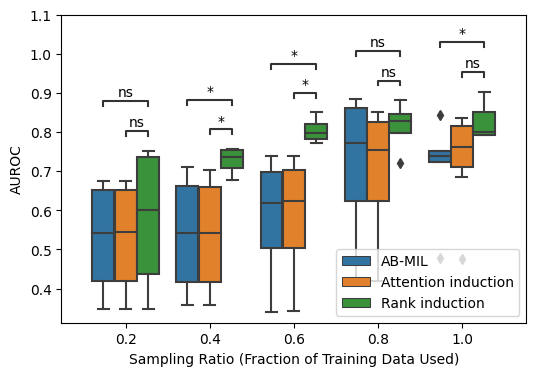

In [5]:
from matplotlib import pyplot as plt
from statannot import add_stat_annotation

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=data_view, x="params.sampling_ratio", y="metrics.test_auroc", hue="params.learning")
ax.set_xlabel("Sampling Ratio (Fraction of Training Data Used)")
ax.set_ylabel("AUROC")
ax.legend(loc="lower right")

comparsions = list()
sampling_ratios = sorted(data_view["params.sampling_ratio"].unique())
for ratio in sampling_ratios:
    # 각 sampling ratio에 대한 비교 쌍 생성
    comparison = [
        ((ratio, "AB-MIL"), (ratio, "Rank induction")),
        ((ratio, "Attention induction"), (ratio, "Rank induction"))
    ]
    comparsions.extend(comparison)
    
add_stat_annotation(
    ax,
    data=data_view,
    x="params.sampling_ratio",
    y="metrics.test_auroc",
    hue="params.learning",
    box_pairs=comparsions,
    test="Mann-Whitney-ls",  # or "t-test_ind"
    text_format="star",
    loc="inside",
    verbose=2,
    comparisons_correction=None  # 다중 비교 보정 제거
)
